# 3D map simulation

## Prerequisites

- Knowledge of 3D extraction and datasets used in gammapy, see for instance the [first analysis tutorial](../../starting/analysis_1.ipynb)

## Context

To simulate a specific observation, it is not always necessary to simulate the full photon list. For many uses cases, simulating directly a reduced binned dataset is enough: the IRFs reduced in the correct geometry are combined with a source model to predict an actual number of counts per bin. The latter is then used to simulate a reduced dataset using Poisson probability distribution.

This can be done to check the feasibility of a measurement (performance / sensitivity study), to test whether fitted parameters really provide a good fit to the data etc.

Here we will see how to perform a 3D simulation of a CTA observation, assuming both the spectral and spatial morphology of an observed source.

**Objective: simulate a 3D observation of a source with CTA using the CTA 1DC response and fit it with the assumed source model.**

## Proposed approach

Here we can't use the regular observation objects that are connected to a `DataStore`. Instead we will create a fake `~gammapy.data.Observation` that contain some pointing information and the CTA 1DC IRFs (that are loaded with `~gammapy.irf.load_cta_irfs`).

Then we will create a `~gammapy.datasets.MapDataset` geometry and create it with the `~gammapy.makers.MapDatasetMaker`.

Then we will be able to define a model consisting of  a `~gammapy.modeling.models.PowerLawSpectralModel` and a `~gammapy.modeling.models.GaussianSpatialModel`. We will assign it to the dataset and fake the count data.


## Imports and versions

In [1]:
%matplotlib inline

In [79]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.irf import load_cta_irfs
from gammapy.maps import WcsGeom, MapAxis
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    GaussianSpatialModel,
    SkyModel,
    Models,
    FoVBackgroundModel,
)
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.modeling import Fit
from gammapy.data import Observation, observatory_locations
from gammapy.datasets import MapDataset
from regions import CircleSkyRegion

In [3]:
!gammapy info --no-envvar --no-dependencies --no-system


Gammapy package:

	version                : 0.20.1     
	path                   : D:\Documents\Miniconda\envs\gammapy-0.20.1\lib\site-packages\gammapy 



## Simulation

We will simulate using the CTA-1DC IRFs shipped with gammapy. Note that for dedictaed CTA simulations, you can simply use [`Observation.from_caldb()`]() without having to externally load the IRFs

In [4]:
# Loading IRFs
irfs = load_cta_irfs(
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


In [5]:
# Define the observation parameters (typically the observation duration and the pointing position):
livetime = 2.0 * u.hr
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")

In [6]:
# Define map geometry for binned simulation
energy_reco = MapAxis.from_edges(
    np.logspace(-1.0, 1.0, 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(6, 6),
    frame="galactic",
    axes=[energy_reco],
)
# It is usually useful to have a separate binning for the true energy axis
energy_true = MapAxis.from_edges(
    np.logspace(-1.5, 1.5, 30), unit="TeV", name="energy_true", interp="log"
)

empty = MapDataset.create(
    geom, name="dataset-simu", energy_axis_true=energy_true
)

Here we start changing things respect the original tutorial, introducing this time two separate gaussians in our FoV

In [67]:
# Define sky model to used simulate the data.
# Here we use a Gaussian spatial model and a Power Law spectral model.
spatial_model1 = GaussianSpatialModel(
    lon_0=2*u.deg, lat_0=2*u.deg, sigma=0.3*u.deg, frame="galactic"
)
spatial_model1.lon_0.min = spatial_model1.lon_0.value - 0.5
spatial_model1.lon_0.max = spatial_model1.lon_0.value + 0.5
spatial_model1.lat_0.min = spatial_model1.lat_0.value - 0.5
spatial_model1.lat_0.max = spatial_model1.lat_0.value + 0.5
spectral_model1 = PowerLawSpectralModel(
    index=3, amplitude="1e-11 cm-2 s-1 TeV-1", reference="1 TeV"
)
model_simu1 = SkyModel(
    spatial_model=spatial_model1,
    spectral_model=spectral_model1,
    name="model-simu1",
)
spatial_model2 = GaussianSpatialModel(
    lon_0="-2 deg", lat_0="-2 deg", sigma="0.3 deg", frame="galactic"
)
spatial_model2.lon_0.min = spatial_model2.lon_0.value - 0.5
spatial_model2.lon_0.max = spatial_model2.lon_0.value + 0.5
spatial_model2.lat_0.min = spatial_model2.lat_0.value - 0.5
spatial_model2.lat_0.max = spatial_model2.lat_0.value + 0.5
spectral_model2 = PowerLawSpectralModel(
    index=3, amplitude="1e-11 cm-2 s-1 TeV-1", reference="1 TeV"
)
model_simu2 = SkyModel(
    spatial_model=spatial_model2,
    spectral_model=spectral_model2,
    name="model-simu2",
)
bkg_model = FoVBackgroundModel(dataset_name="dataset-simu")

models = Models([model_simu1, model_simu2, bkg_model])
print(models)

Models

Component 0: SkyModel

  Name                      : model-simu1
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      3.000   +/-    0.00             
    amplitude                     :   1.00e-11   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                         :      2.000   +/-    0.00 deg         
    lat_0                         :      2.000   +/-    0.00 deg         
    sigma                         :      0.300   +/-    0.00 deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         

Component 1: SkyModel

  Name                      : model-simu2
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model typ

Now, comes the main part of dataset simulation. We create an in-memory observation and an empty dataset. We then predict the number of counts for the given model, and Poission fluctuate it using `fake()` to make a simulated counts maps. Keep in mind that it is important to specify the `selection` of the maps that you want to produce 

In [68]:
# Create an in-memory observation
location = observatory_locations["cta_south"]
obs = Observation.create(
    pointing=pointing, livetime=livetime, irfs=irfs, location=location
)
print(obs)

Observation

	obs id            : 0 
 	tstart            : 51544.00
	tstop             : 51544.08
	duration          : 7200.00 s
	pointing (icrs)   : 266.4 deg, -28.9 deg

	deadtime fraction : 0.0%



In [69]:
# Make the MapDataset
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])

maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=4.0 * u.deg)

dataset = maker.run(empty, obs)
dataset = maker_safe_mask.run(dataset, obs)
print(dataset)

MapDataset
----------

  Name                            : dataset-simu 

  Total counts                    : 0 
  Total background counts         : 161250.95
  Total excess counts             : -161250.95

  Predicted counts                : 161250.95
  Predicted background counts     : 161250.95
  Predicted excess counts         : nan

  Exposure min                    : 4.08e+02 m2 s
  Exposure max                    : 3.58e+10 m2 s

  Number of total bins            : 810000 
  Number of fit bins              : 804492 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




In [70]:
# Add the model on the dataset and Poission fluctuate
dataset.models = models
dataset.fake()
# Do a print on the dataset - there is now a counts maps
print(dataset)

MapDataset
----------

  Name                            : dataset-simu 

  Total counts                    : 170827 
  Total background counts         : 161250.95
  Total excess counts             : 9576.05

  Predicted counts                : 171440.36
  Predicted background counts     : 161250.95
  Predicted excess counts         : 10189.42

  Exposure min                    : 4.08e+02 m2 s
  Exposure max                    : 3.58e+10 m2 s

  Number of total bins            : 810000 
  Number of fit bins              : 804492 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 572572.55

  Number of models                : 3 
  Number of parameters            : 19
  Number of free parameters       : 11

  Component 0: SkyModel
  
    Name                      : model-simu1
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model type       : 
    Param

Now use this dataset as you would in all standard analysis. You can plot the maps, or proceed with your custom analysis. 
In the next section, we show the standard 3D fitting as in [analysis_3d](analysis_3d.ipynb).

In [71]:
# To plot, eg, counts:
dataset.counts.smooth(0.05 * u.deg).plot_interactive(
    add_cbar=True, stretch="linear"
)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

We see two sources in the positions specified, as expected

## Fit

In this section, we do a usual 3D fit with the same model used to simulated the data and see the stability of the simulations. Often, it is useful to simulate many such datasets and look at the distribution of the reconstructed parameters.

In [72]:
models_fit = models.copy()

In [73]:
# We do not want to fit the background in this case, so we will freeze the parameters
models_fit["dataset-simu-bkg"].spectral_model.norm.frozen = True
models_fit["dataset-simu-bkg"].spectral_model.tilt.frozen = True

In [74]:
dataset.models = models_fit
print(dataset.models)

DatasetModels

Component 0: SkyModel

  Name                      : model-simu1
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      3.000   +/-    0.00             
    amplitude                     :   1.00e-11   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                         :      2.000   +/-    0.00 deg         
    lat_0                         :      2.000   +/-    0.00 deg         
    sigma                         :      0.300   +/-    0.00 deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         

Component 1: SkyModel

  Name                      : model-simu2
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  mo

In [75]:
%%time
fit = Fit(optimize_opts={"print_level": 1})
result = fit.run(datasets=[dataset])

W VariableMetricBuilder Reached machine accuracy limit; Edm 0.000531374 is smaller than machine limit 0.0341273 while 0.0002 was requested
CPU times: total: 56.1 s
Wall time: 56.1 s


<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

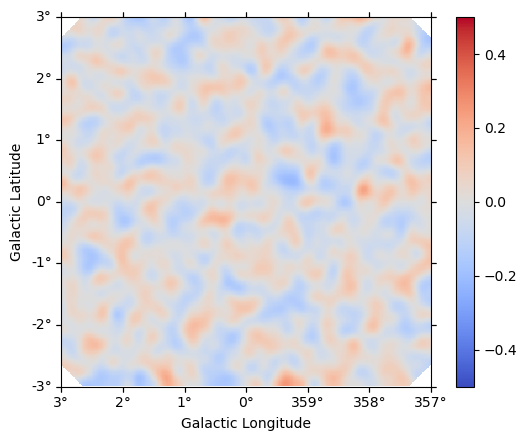

In [76]:
dataset.plot_residuals_spatial(method="diff/sqrt(model)", vmin=-0.5, vmax=0.5)

We now compute the spectral residuals in the region of the 2 sources

(<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>,
 <AxesSubplot:xlabel='Energy [TeV]', ylabel='Residuals (data - model)'>)

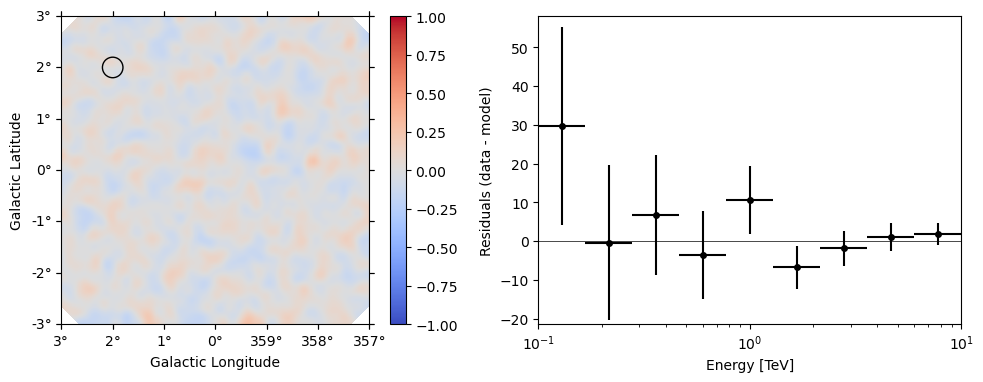

In [82]:
region = CircleSkyRegion(spatial_model1.position, radius=0.20 * u.deg)
dataset.plot_residuals(
    kwargs_spatial=dict(method="diff/sqrt(model)", vmin=-1, vmax=1),
    kwargs_spectral=dict(region=region),
)

(<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>,
 <AxesSubplot:xlabel='Energy [TeV]', ylabel='Residuals (data - model)'>)

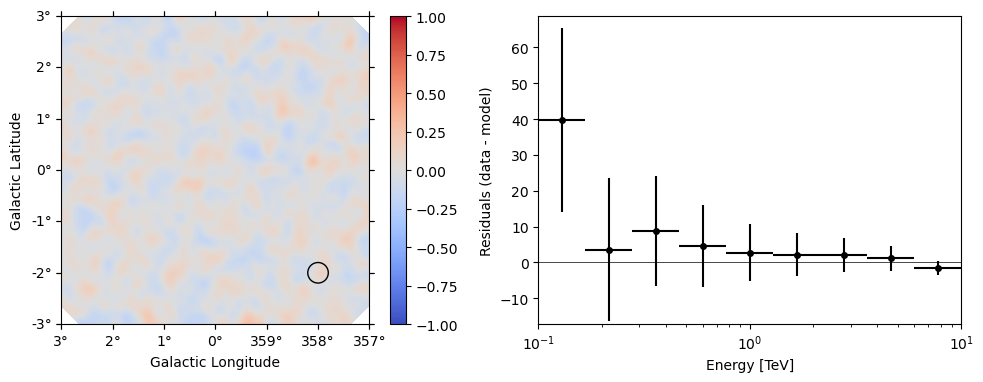

In [83]:
region = CircleSkyRegion(spatial_model2.position, radius=0.20 * u.deg)
dataset.plot_residuals(
    kwargs_spatial=dict(method="diff/sqrt(model)", vmin=-1, vmax=1),
    kwargs_spectral=dict(region=region),
)